In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
import torch
import re
import statsmodels

In [ ]:
df = pd.read_csv("imdb_top_1000.csv")

In [ ]:
df.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [ ]:
def parse_gross(value):
    if pd.isna(value):
        return np.nan
    # Remove any non-numeric characters like $, commas, etc.
    value = re.sub(r'[^0-9.]', '', str(value))
    try:
        return float(value)
    except:
        return np.nan

In [ ]:
df['Gross_Float'] = df['Gross'].apply(parse_gross)

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
bert_sentiment = pipeline("sentiment-analysis") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\khana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [ ]:
# --- VADER ---
df['vader_score'] = df['Overview'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# --- TextBlob ---
df['textblob_polarity'] = df['Overview'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


In [30]:
df[['Overview','vader_score', 'textblob_polarity']] 

,Overview,vader_score,textblob_polarity
0,Two imprisoned men bond over a number of years...,-0.4019,-0.300000
1,An organized crime dynasty's aging patriarch t...,-0.6705,0.000000
2,When the menace known as the Joker wreaks havo...,-0.8176,0.333333
3,The early life and career of Vito Corleone in ...,-0.4767,0.118182
4,A jury holdout attempts to prevent a miscarria...,0.5423,0.000000
...,...,...,...
995,A young New York socialite becomes interested ...,-0.3716,0.067273
996,Sprawling epic covering the life of a Texas ca...,0.0000,0.100000
997,"In Hawaii in 1941, a private is cruelly punish...",-0.4939,-0.166667
998,Several survivors of a torpedoed merchant ship...,-0.5994,0.000000


In [ ]:
def get_bert_score(text):
    try:
        result = bert_sentiment(text[:512])[0]  
        return result['score'] if result['label'] == 'POSITIVE' else -result['score']
    except:
        return np.nan

df['bert_score'] = df['Overview'].astype(str).apply(get_bert_score)

In [ ]:
# ------------------------------------------------------------
# 4. Explore Correlation with IMDB Rating & Box Office Gross
# ------------------------------------------------------------
df['Gross_Float'] = pd.to_numeric(df['Gross_Float'], errors='coerce')

# --- Correlations ---
corr_vader_rating = df['vader_score'].corr(df['IMDB_Rating'])
corr_vader_gross  = df['vader_score'].corr(df['Gross_Float'])
corr_tb_rating    = df['textblob_polarity'].corr(df['IMDB_Rating'])
corr_tb_gross     = df['textblob_polarity'].corr(df['Gross_Float'])
corr_bert_rating  = df['bert_score'].corr(df['IMDB_Rating'])
corr_bert_gross   = df['bert_score'].corr(df['Gross_Float'])

print("\n🔍 CORRELATION RESULTS")
print(f"VADER → Rating: {corr_vader_rating:.3f} | Gross: {corr_vader_gross:.3f}")
print(f"TextBlob → Rating: {corr_tb_rating:.3f} | Gross: {corr_tb_gross:.3f}")
print(f"BERT → Rating: {corr_bert_rating:.3f} | Gross: {corr_bert_gross:.3f}")


🔍 CORRELATION RESULTS
VADER → Rating: -0.070 | Gross: -0.031
TextBlob → Rating: -0.055 | Gross: 0.021
BERT → Rating: 0.061 | Gross: 0.055


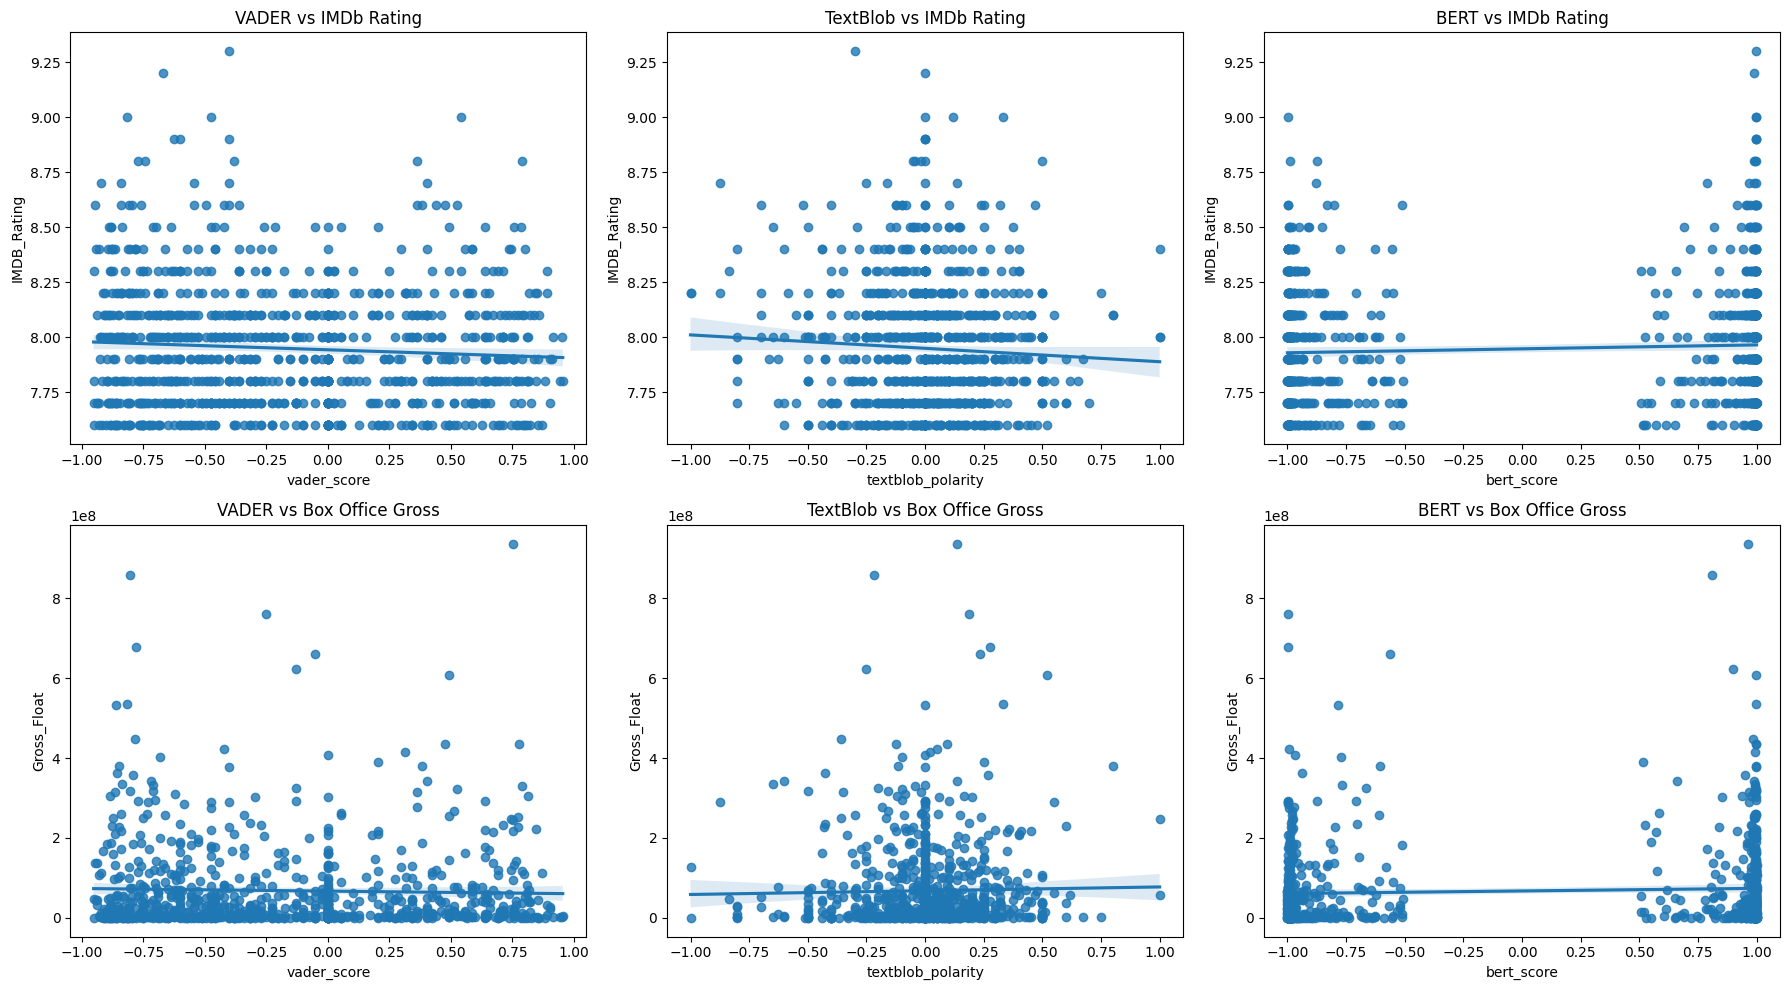

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
methods = ['vader_score', 'textblob_polarity', 'bert_score']
titles = ['VADER', 'TextBlob', 'BERT']

for i, method in enumerate(methods):
    sns.regplot(x=df[method], y=df['IMDB_Rating'], ax=axes[0, i])
    axes[0, i].set_title(f'{titles[i]} vs IMDb Rating')
    sns.regplot(x=df[method], y=df['Gross_Float'], ax=axes[1, i])
    axes[1, i].set_title(f'{titles[i]} vs Box Office Gross')

plt.tight_layout()
plt.show()
